<a href="https://colab.research.google.com/github/ritagord/Merging_dynamics/blob/main/Gillespie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, widgets
from IPython.display import display
import time

from mpl_toolkits.mplot3d import Axes3D

### Starting with a gaussian around 20 as our initial distribution of mass over droplet radii

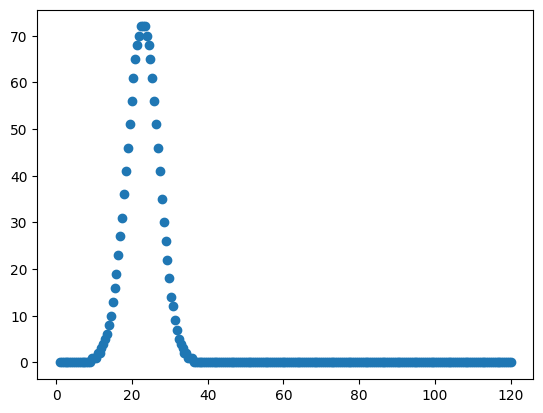

In [2]:
def gaussian(x, mean, std_dev):
    return 10**7*(1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

# Compute counts for each radius
counts = [round(gaussian(r, mean = 25, std_dev = 4)/r**3) for r in np.linspace(1, 120, 240)]

# Plotting
plt.plot(np.linspace(1, 120, 240), counts, 'o')

In [3]:
values_array = np.linspace(1, 50, 100)
keys = np.arange(0, len(values_array))
value_dict = dict(zip(keys, values_array))

print(value_dict)

{0: 1.0, 1: 1.494949494949495, 2: 1.98989898989899, 3: 2.484848484848485, 4: 2.97979797979798, 5: 3.474747474747475, 6: 3.9696969696969697, 7: 4.464646464646465, 8: 4.95959595959596, 9: 5.454545454545455, 10: 5.94949494949495, 11: 6.444444444444445, 12: 6.9393939393939394, 13: 7.434343434343434, 14: 7.92929292929293, 15: 8.424242424242426, 16: 8.91919191919192, 17: 9.414141414141415, 18: 9.90909090909091, 19: 10.404040404040405, 20: 10.8989898989899, 21: 11.393939393939394, 22: 11.88888888888889, 23: 12.383838383838384, 24: 12.878787878787879, 25: 13.373737373737374, 26: 13.868686868686869, 27: 14.363636363636365, 28: 14.85858585858586, 29: 15.353535353535355, 30: 15.84848484848485, 31: 16.343434343434346, 32: 16.83838383838384, 33: 17.333333333333336, 34: 17.82828282828283, 35: 18.323232323232325, 36: 18.81818181818182, 37: 19.313131313131315, 38: 19.80808080808081, 39: 20.303030303030305, 40: 20.7979797979798, 41: 21.292929292929294, 42: 21.78787878787879, 43: 22.282828282828284, 44:

### Defining the form of reaction constant depending on some r0 - a function of r_j,  r_j - radii of merging particles

In [4]:
#For larger radii almost the same as for small
def k_react_func(r0):
    r0 = np.array(r0)
    result = np.zeros_like(r0, dtype=float)
    result[r0 > 6] = 5*10**(-5) + 10**(-6)
    result[(r0 > 3) & (r0 <= 5)] = 10**(-6)
    result[(r0 > 5) & (r0 <= 6)] = 5*10**(-5) * r0[(r0 > 5) & (r0 <= 6)] - 2.5*10**(-4) + 10**(-6)
    result[r0 <= 3] = 0.9*10**(-4) + 10**(-6) - 3*10**(-5) * r0[r0 <= 3]
    return result

print(k_react_func(20/10))

3.0999999999999995e-05


In [42]:
#For larger radii considerably less than for small
def k_react_func(r0):
    r0 = np.array(r0)
    result = np.zeros_like(r0, dtype=float)
    result[r0 > 5] = 10**(-5) + 10**(-6)
    result[(r0 > 3) & (r0 <= 4)] = 10**(-6)
    result[(r0 > 4) & (r0 <= 5)] = 1*10**(-5) * r0[(r0 > 4) & (r0 <= 5)] - 4*10**(-5) + 10**(-6)
    result[r0 <= 3] = 0.9*10**(-4) + 10**(-6) - 3*10**(-5) * r0[r0 <= 3]
    return 5*result

print(k_react_func(20/10))

0.00015499999999999997


Text(0.5, 0, 'r0')

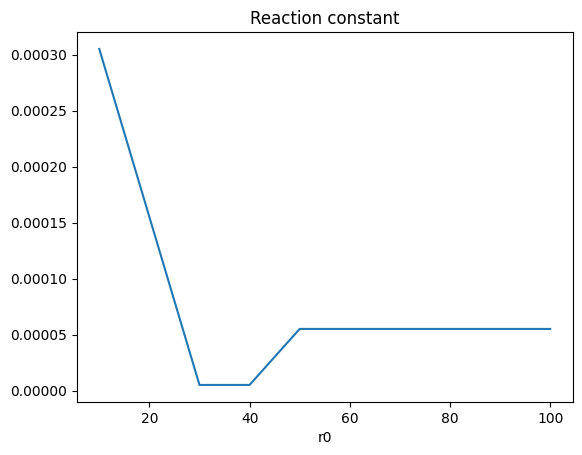

In [43]:
plt.title("Reaction constant")
plt.plot(np.linspace(10, 100, 1000), k_react_func(np.linspace(10, 100, 1000)/10), label = "reaction")
plt.xlabel("r0")

We are imposing such a dependence on the constant of reaction to hopefully achieve a double-peak distribution for radii smaller and larger than the local minimum

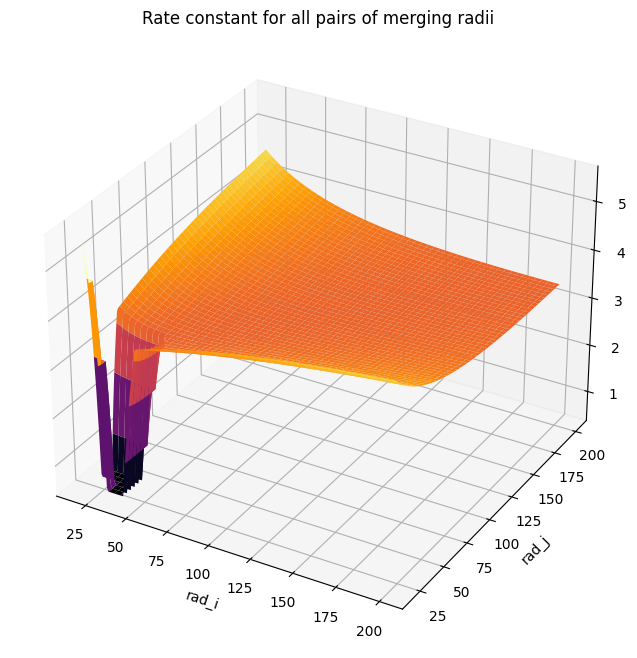

In [44]:
rad_i_values = np.linspace(20, 200, 200)
rad_j_values = np.linspace(20, 200, 200)
rad_i_grid, rad_j_grid = np.meshgrid(rad_i_values, rad_j_values)

V = (50)**3
kbT = 4.12 * 10**(-3)
mu = 1*10**(-3)


k_diff = (2 * kbT / (3 * mu * V)) * (2 + (rad_i_grid / rad_j_grid) + (rad_j_grid / rad_i_grid))
r0 = np.maximum(rad_i_grid, rad_j_grid)/10

#def k_react_func(r0):
#    r0 = np.array(r0)
#    result = np.zeros_like(r0, dtype=float)
#    result[r0 > 6] = 2*10**(-5)
#    result[(r0 > 3) & (r0 <= 6)] = 10**(-5) + 10**(-6) * r0[(r0 > 3) & (r0 <= 6)]
#    result[r0 <= 3] = 5*10**(-5) - 5*10**(-6) * r0[r0 <= 3]
#    return result*5

k_react = k_react_func(r0)

k_rates = np.multiply(np.multiply(k_diff, k_react), np.power(np.add(k_diff, k_react), -1))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Rate constant for all pairs of merging radii")
surf = ax.plot_surface(rad_i_grid, rad_j_grid, k_rates, cmap='inferno')

ax.set_xlabel('rad_i')
ax.set_ylabel('rad_j')
ax.set_zlabel('k_rates')
plt.show()

Checking that k_diff and k_react have similar scales

In [21]:
print("Maximum reaction constant: ", np.max(k_react))
print("Maximum diffusion constant: ", np.max(k_diff))

Maximum reaction constant:  0.00015499999999999997
Maximum diffusion constant:  0.00026587733333333335


We can try both r0 = max(r1, r2) and r0 = geom_sum(r1, r2)

In [22]:
start_time = time.time()
#np.random.seed(234)               # For reproducing

steps = 2*10**3                    # Not time - number of reactions to occur

#Np0 = steps + 1                   # Initial number of monomers
Np0 = 10**4

Np = int(5000)                     # Expected amount of different droplet sizes

radii_dict = value_dict            # Mapping of i index in arrays to an actual radius

T = np.zeros(steps)                # Time

N_olig = np.zeros((Np, steps))     # Array storing amounts of particles of each size

N_olig[:len(counts),0] = counts    # Initial distribution (gaussian)


#  Constants:

V = (50)**3
kbT = 4.12 * 10**(-3)
mu = 1*10**(-3)

"""
  Main loop:

"""
s = 0

while (s+1) < steps:
        N_step = np.array(N_olig[:len(radii_dict), s])
        R = 0       # Total rate for this step

        # Calculate reaction rates
        radii_arr = np.array([radii_dict[i] for i in range(len(radii_dict))])
        rad_i = radii_arr[:, np.newaxis]
        rad_j = radii_arr[np.newaxis, :]

        k_diff = (2*kbT/(3*mu*V)) * (2 + ((rad_i) / (rad_j)) + ((rad_j) / (rad_i)))

        r0 = rad_i * rad_j / (rad_i + rad_j)
        #r0 = np.minimum(rad_i, rad_j)/10
        k_react = k_react_func(r0)
        k_rates = np.multiply(np.multiply(k_diff, k_react), np.power(np.add(k_diff, k_react), -1))

        N_step_i = N_step[:, np.newaxis]
        N_step_j = N_step[np.newaxis, :]

        rates = k_rates * N_step_i * N_step_j
        np.fill_diagonal(rates, (1/2) * np.diagonal(k_rates) * N_step * (N_step - 1)) #different rate for i = j

        R = np.sum(np.triu(rates))
        if R == 0:
            print("zero total rate!", rates)

        # Find time to next reaction
        u1 = np.random.uniform(0, 1)
        tau = 1/R * np.log(1/u1)

        # Store reaction time
        T[s+1] = T[s] + tau

        # Choose the merging pair
        probs = rates/rates.sum()
        A = np.array(list(np.ndindex(len(radii_dict),len(radii_dict))))
        [p, q] = A[np.random.choice(a = np.arange(len(A)), p = probs.flatten(), replace=False)]

        # Remove the reacted pair for the next step
        N_olig[:, s+1] = N_olig[:, s]

        if p == q:
            N_olig[p, s+1] = N_olig[p, s] - 2 # merging of two equal size droplets
        else:
            N_olig[p, s+1] = N_olig[p, s] - 1 # merging of different droplets
            N_olig[q, s+1] = N_olig[q, s] - 1

        # Add new droplet
        combined_radius = (radii_dict[p]**3 + radii_dict[q]**3)**(1/3)

        if combined_radius not in radii_dict.values(): # expand the dictionary with new value
            new_index = len(radii_dict)
            radii_dict[new_index] = combined_radius

        else:
            new_index = [k for k, v in radii_dict.items() if v == combined_radius][0] # find index of radius in dict

        N_olig[new_index, s+1] += 1

        # Check whether it's possible to continue merging
        if sum(N_olig[:, s+1]) == 1:
            print("1 droplet left at step", s+1)
            break

        s += 1

print(len(radii_dict.values()), "different particle sizes") # used to estimate Np needed
print("time", time.time() - start_time)

1 droplet left at step 1531
1450 different particle sizes
time 1129.2566905021667


In [24]:
def mass_hist(current_nt):

    plt.figure()
    all_radii = list(radii_dict.values())
    mass_per_radius = [n*r**3 for (r, n) in zip(all_radii, N_olig[:len(all_radii), current_nt])]

    #plt.bar(all_radii, N_olig[:len(all_radii), current_nt]) #number plot
    plt.bar(all_radii, mass_per_radius) #mass plot

    plt.title(f"Histogram for time (seconds) = {round(T[current_nt], 3)}")
    plt.xlabel("Droplet radius")
    plt.ylabel("N(R)*R^3")
    plt.xlim(20, 150)
    #plt.ylim(0, 2000)
    #plt.legend()
    plt.show()

interact(mass_hist, current_nt=widgets.IntSlider(min=0, max=1500 , step=int(50), value=0))


interactive(children=(IntSlider(value=0, description='current_nt', max=1500, step=50), Output()), _dom_classes…

<function __main__.mass_hist(current_nt)>

In [28]:
radii_dict_save = radii_dict

In [29]:
# Can define s_start - starting point for the next simulation
# Here I chose 650 to try to curb the increaser of droplet radius

s_start = 650
N_olig_save = N_olig[:, s_start]

### Starting from previous simulation


Changing the k react here but it should not matter since the change is for radii larger than what we had

Text(0.5, 0, 'r0')

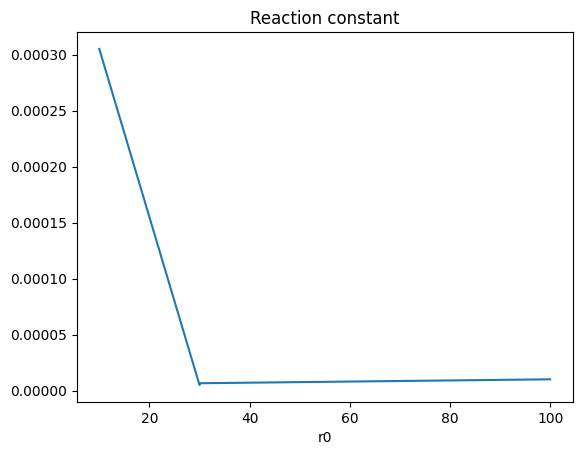

In [45]:
# new k_react-------
def k_react_func(r0):
    r0 = np.array(r0)
    result = np.zeros_like(r0, dtype=float)
    result[(r0 > 3)] = 10**(-6) + 10**(-7)*r0[(r0 > 3)]
    result[r0 <= 3] = 0.9*10**(-4) + 10**(-6) - 3*10**(-5) * r0[r0 <= 3]
    return 5*result
#---------
plt.title("Reaction constant")
plt.plot(np.linspace(10, 100, 1000), k_react_func(np.linspace(10, 100, 1000)/10), label = "reaction")
plt.xlabel("r0")

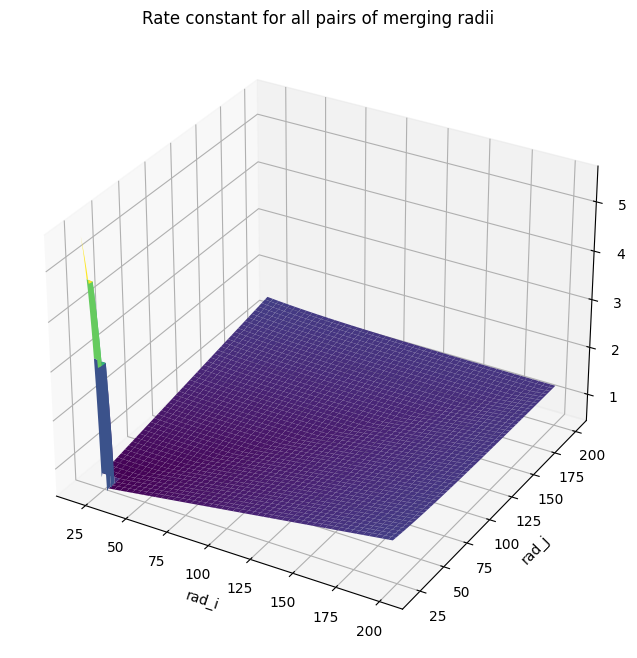

In [46]:
rad_i_values = np.linspace(20, 200, 200)
rad_j_values = np.linspace(20, 200, 200)
rad_i_grid, rad_j_grid = np.meshgrid(rad_i_values, rad_j_values)

V = (50)**3
kbT = 4.12 * 10**(-3)
mu = 1*10**(-3)


k_diff = (2 * kbT / (3 * mu * V)) * (2 + (rad_i_grid / rad_j_grid) + (rad_j_grid / rad_i_grid))
r0 = np.maximum(rad_i_grid, rad_j_grid)/10

k_react = k_react_func(r0)

k_rates = np.multiply(np.multiply(k_diff, k_react), np.power(np.add(k_diff, k_react), -1))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Rate constant for all pairs of merging radii")
surf = ax.plot_surface(rad_i_grid, rad_j_grid, k_rates, cmap='viridis')

ax.set_xlabel('rad_i')
ax.set_ylabel('rad_j')
ax.set_zlabel('k_rates')
plt.show()

In [30]:
start_time = time.time()
#np.random.seed(234)  # for reproducing

steps = 5*10**2   # not time
#Np0 = steps + 1     # Initial number of monomers
Np0 = 10**4
Np = int(5000)

radii_dict = radii_dict_save # Mapping of i index in arrays to an actual radius

T = np.zeros(steps) # time
N_olig = np.zeros((Np, steps))
N_olig[:,0] = N_olig_save

# Constants
V = (50)**3 # Volume (um)
#kbT = 1
kbT = 4.12 * 10**(-3)
#mu = 1/(6*np.pi)
mu = 1*10**(-3)



# Main
s = 0
#while sum(N_olig[:, s]) >1:
while (s+1) < steps:
        N_step = np.array(N_olig[:len(radii_dict), s])
        R = 0 #total rate for this step

        # Reaction rates calculation
        radii_arr = np.array([radii_dict[i] for i in range(len(radii_dict))])

        rad_i = radii_arr[:, np.newaxis]
        rad_j = radii_arr[np.newaxis, :]

        k_diff = (2*kbT/(3*mu*V)) * (2 + ((rad_i) / (rad_j)) + ((rad_j) / (rad_i)))

        r0 = rad_i * rad_j / (rad_i + rad_j)
        #r0 = np.maximum(rad_i, rad_j)/10
        k_react = k_react_func(r0)
        k_rates = np.multiply(np.multiply(k_diff, k_react), np.power(np.add(k_diff, k_react), -1))


        N_step_i = N_step[:, np.newaxis]
        N_step_j = N_step[np.newaxis, :]

        rates = k_rates * N_step_i * N_step_j #rates for i, j pairs

        np.fill_diagonal(rates, (1/2) * np.diagonal(k_rates) * N_step * (N_step - 1)) #different rate for i = j
        R = np.sum(np.triu(rates))

        if R == 0:
            print("zero total rate!", rates)

        # Calculate time to next reaction
        u1 = np.random.uniform(0, 1)
        tau = 1/R * np.log(1/u1)

        # Store reaction time
        T[s+1] = T[s] + tau

        # Choose the merging pair
        probs = rates/rates.sum()
        A = np.array(list(np.ndindex(len(radii_dict),len(radii_dict))))
        [p, q] = A[np.random.choice(a = np.arange(len(A)), p = probs.flatten(), replace=False)]

        # Remove the reacted pair for the next step
        N_olig[:, s+1] = N_olig[:, s]

        if p == q:
            N_olig[p, s+1] = N_olig[p, s] - 2 #for merging of two equal size droplets

        else:
            N_olig[p, s+1] = N_olig[p, s] - 1 #for merging of different droplets
            N_olig[q, s+1] = N_olig[q, s] - 1

        # Add new droplet
        combined_radius = (radii_dict[p]**3 + radii_dict[q]**3)**(1/3)

        if combined_radius not in radii_dict.values(): #expand the dictionary with new value
            new_index = len(radii_dict)
            radii_dict[new_index] = combined_radius

        else:
            new_index = [k for k, v in radii_dict.items() if v == combined_radius][0] #find index of radius in dict

        N_olig[new_index, s+1] += 1

        if sum(N_olig[:, s+1]) == 1:
            print("1 droplet left at step", s+1)
            break

        s += 1

print(len(radii_dict.values()), "different particle sizes")
print("time", time.time() - start_time)

1886 different particle sizes
time 1445.414371728897


In [47]:
def mass_hist(current_nt):

    plt.figure()
    all_radii = list(radii_dict.values())
    mass_per_radius = [n*r**3 for (r, n) in zip(all_radii, N_olig[:len(all_radii), current_nt])]

    #plt.bar(all_radii, N_olig[:len(all_radii), current_nt]) #number plot
    plt.bar(all_radii, mass_per_radius) #mass plot

    plt.title(f"Mass histogram for time (seconds) = {round(T[current_nt], 3)}")
    plt.xlabel("Droplet radius")
    plt.ylabel("N(R)*R^3")
    plt.xlim(10, 150)
    #plt.ylim(0, 2000)
    #plt.legend()
    plt.show()

interact(mass_hist, current_nt=widgets.IntSlider(min=0, max=steps-50 , step=int(50), value=0))


interactive(children=(IntSlider(value=0, description='current_nt', max=450, step=50), Output()), _dom_classes=…

<function __main__.mass_hist(current_nt)>

In [48]:
def mass_hist(current_nt):

    plt.figure()
    all_radii = list(radii_dict.values())
    mass_per_radius = [n*r**3 for (r, n) in zip(all_radii, N_olig[:len(all_radii), current_nt])]


    plt.bar(all_radii, N_olig[:len(all_radii), current_nt]) #number plot

    #plt.bar(all_radii, mass_per_radius) #mass plot

    plt.title(f"Number histogram for time (seconds) = {round(T[current_nt], 3)}")
    plt.xlabel("Droplet radius")
    plt.ylabel("N(R)*R^3")
    plt.xlim(10, 150)
    #plt.ylim(0, 2000)
    #plt.legend()
    plt.show()

interact(mass_hist, current_nt=widgets.IntSlider(min=0, max=steps-50 , step=int(50), value=0))


interactive(children=(IntSlider(value=0, description='current_nt', max=450, step=50), Output()), _dom_classes=…

<function __main__.mass_hist(current_nt)>

So the reason we don't get two normal peaks is because we have too little droplets which is hard to fix here because of simulation time so we resort to bootstrap on cluster